In [41]:
import operator
import random
import os
import io

import numpy
import math

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
import time
import collections

## Basic PSO

In [42]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best=None)

d:\Python\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Python\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [43]:
#
def generate_particle(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) #underscore means the variable is not used outside of the written line
    part.speed = [random.uniform(smin, smax) for _ in range(size)] #random.uniform(a,b) == [a,b]
    part.smin = smin
    part.smax = smax
    return part

In [44]:
#The function first computes the speed, then limits the speed values between smin and smax, 
#and finally computes the new particle position.
def update_particle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part)) #v_u1 = u1*(part.best - part)
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part)) #v_u2 = u2*(best - part)
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2))) #part.speed = list(part.speed+(v_u1+v_u2))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part[:] = list(map(operator.add, part, part.speed))

In [45]:
toolbox = base.Toolbox()
toolbox.register("particle", generate_particle, size=2, pmin=-6, pmax=6, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", update_particle, phi1=2.0, phi2=2.0)
toolbox.register("evaluate", benchmarks.h1)

In [46]:
def main():
    pop = toolbox.population(n=5)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    GEN = 1000
    best = None

    for g in range(GEN):
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        for part in pop:
            toolbox.update(part, best)

        # Gather all the fitnesses in one list and print the stats
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        print(logbook.stream)

    return pop, logbook, best

In [47]:
if __name__ == "__main__":
    main()

gen	evals	avg      	std       	min      	max      
0  	5    	0.0793903	0.00763755	0.0675203	0.0888866
1  	5    	0.0688364	0.0406467 	0.0144582	0.117829 
2  	5    	0.0591822	0.0329887 	0.0149175	0.105049 
3  	5    	0.0875118	0.0268099 	0.0442653	0.116491 
4  	5    	0.0819587	0.0301058 	0.0503932	0.13802  
5  	5    	0.103326 	0.0361194 	0.0363125	0.143612 
6  	5    	0.0830978	0.0515686 	0.00292582	0.140502 
7  	5    	0.0812667	0.030526  	0.0443281 	0.119077 
8  	5    	0.0802547	0.0429456 	0.046211  	0.162582 
9  	5    	0.0868817	0.0109364 	0.0763751 	0.107879 
10 	5    	0.0977256	0.0503619 	0.017423  	0.158809 
11 	5    	0.0890302	0.0425007 	0.0179697 	0.1337   
12 	5    	0.0559765	0.0360471 	0.0188139 	0.108569 
13 	5    	0.101606 	0.0491557 	0.0210593 	0.159451 
14 	5    	0.0377211	0.0266246 	0.0028714 	0.0723682
15 	5    	0.103873 	0.0372936 	0.0611716 	0.154811 
16 	5    	0.0691121	0.0377514 	0.0321412 	0.136324 
17 	5    	0.0818513	0.0156871 	0.060931  	0.102522 
18 	5    	0.0514604

## Data 

In [48]:
X_COORD = 'x'
Y_COORD = 'y'
COORDINATES = 'coordinates'
INSTANCE_NAME = 'instance_name'
MAX_VEHICLE_NUMBER = 'max_vehicle_number'
VEHICLE_CAPACITY = 'vehicle_capacity'
DEPART = 'depart'
DEMAND = 'demand'
READY_TIME = 'ready_time'
DUE_TIME = 'due_time'
SERVICE_TIME = 'service_time'
DISTANCE_MATRIX = 'distance_matrix'

In [49]:
def calculate_distance(cust_1, cust_2):
    x_diff = cust_1[COORDINATES][X_COORD] - cust_2[COORDINATES][X_COORD]
    y_diff = cust_1[COORDINATES][Y_COORD] - cust_2[COORDINATES][Y_COORD]
    return (x_diff**2 + y_diff**2)**0.5

In [50]:
cust_num = 0
text_file = 'Data\\c102.txt'
parsed_data = {}
with open(text_file, 'rt', newline='') as fo:
    for line_count, line in enumerate(fo, start=1):
        if line_count == 1:
            parsed_data[INSTANCE_NAME] = line.strip()
        elif line_count == 5:
            values = line.strip().split()
            parsed_data[MAX_VEHICLE_NUMBER] = int(values[0])
            parsed_data[VEHICLE_CAPACITY] = float(values[1])
        elif line_count == 10:
            # DEPART
            values = line.strip().split()
            parsed_data[DEPART] = {
                COORDINATES: {
                    X_COORD: float(values[1]),
                    Y_COORD: float(values[2]),
                },
                DEMAND: float(values[3]),
                READY_TIME: float(values[4]),
                DUE_TIME: float(values[5]),
                SERVICE_TIME: float(values[6]),
            }
        elif line_count > 10:
            # CUSTOMERS
            values = line.strip().split()
            parsed_data[F'C_{values[0]}'] = {
                COORDINATES: {
                    X_COORD: float(values[1]),
                    Y_COORD: float(values[2]),
                },
                DEMAND: float(values[3]),
                READY_TIME: float(values[4]),
                DUE_TIME: float(values[5]),
                SERVICE_TIME: float(values[6]),
            }
            cust_num += 1
        else:
            pass

    customers = [DEPART] + [F'C_{x}' for x in range(1, cust_num+1)]
    parsed_data[DISTANCE_MATRIX] = \
        [[calculate_distance(parsed_data[c1], parsed_data[c2]) for c1 in customers] for c2 in customers]

In [51]:
print(parsed_data)

{'instance_name': 'C102', 'max_vehicle_number': 25, 'vehicle_capacity': 200.0, 'depart': {'coordinates': {'x': 40.0, 'y': 50.0}, 'demand': 0.0, 'ready_time': 0.0, 'due_time': 1236.0, 'service_time': 0.0}, 'C_1': {'coordinates': {'x': 45.0, 'y': 68.0}, 'demand': 10.0, 'ready_time': 0.0, 'due_time': 1127.0, 'service_time': 90.0}, 'C_2': {'coordinates': {'x': 45.0, 'y': 70.0}, 'demand': 30.0, 'ready_time': 0.0, 'due_time': 1125.0, 'service_time': 90.0}, 'C_3': {'coordinates': {'x': 42.0, 'y': 66.0}, 'demand': 10.0, 'ready_time': 0.0, 'due_time': 1129.0, 'service_time': 90.0}, 'C_4': {'coordinates': {'x': 42.0, 'y': 68.0}, 'demand': 10.0, 'ready_time': 727.0, 'due_time': 782.0, 'service_time': 90.0}, 'C_5': {'coordinates': {'x': 42.0, 'y': 65.0}, 'demand': 10.0, 'ready_time': 0.0, 'due_time': 1130.0, 'service_time': 90.0}, 'C_6': {'coordinates': {'x': 40.0, 'y': 69.0}, 'demand': 20.0, 'ready_time': 621.0, 'due_time': 702.0, 'service_time': 90.0}, 'C_7': {'coordinates': {'x': 40.0, 'y': 66.

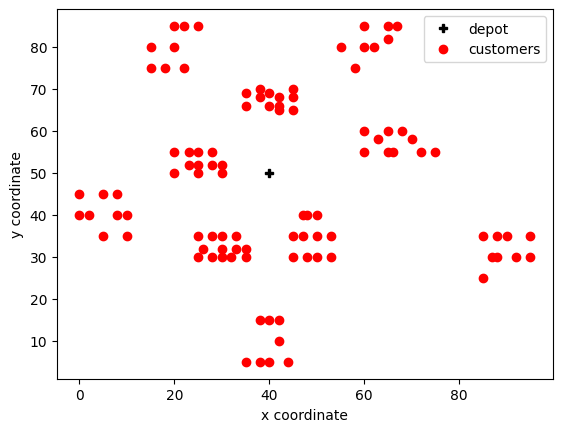

In [52]:
customer_number = 100
instance = parsed_data
depot = [instance[DEPART][COORDINATES][X_COORD], instance[DEPART][COORDINATES][Y_COORD]]
dep, = plt.plot(depot[0], depot[1], 'kP', label='depot')

for customer_id in range(1,customer_number):
    coordinates = [instance[F'C_{customer_id}'][COORDINATES][X_COORD],
                    instance[F'C_{customer_id}'][COORDINATES][Y_COORD]]
    custs, = plt.plot(coordinates[0], coordinates[1], 'ro', label='customers')
plt.ylabel("y coordinate")
plt.xlabel("x coordinate")
plt.legend([dep, custs], ['depot', 'customers'], loc=1)
plt.show()

## Algorithm

In [53]:
def create_route_from_ind(individual, data):

    vehicle_capacity = data[VEHICLE_CAPACITY]
    depart_due_time = data[DEPART][DUE_TIME]

    route = []
    sub_route = []
    vehicle_load = 0
    time_elapsed = 0
    previous_cust_id = 0
    for customer_id in individual:
        demand = data[F'C_{customer_id}'][DEMAND]
        updated_vehicle_load = vehicle_load + demand
        service_time = data[F'C_{customer_id}'][SERVICE_TIME]
        return_time = data[DISTANCE_MATRIX][customer_id][0]
        travel_time = data[DISTANCE_MATRIX][previous_cust_id][customer_id]
        provisional_time = time_elapsed + travel_time + service_time + return_time
        # Validate vehicle load and elapsed time
        if (updated_vehicle_load <= vehicle_capacity) and (provisional_time <= depart_due_time):
            # Add to current sub-route
            sub_route.append(customer_id)
            vehicle_load = updated_vehicle_load
            time_elapsed = provisional_time - return_time
        else:
            # Save current sub-route
            route.append(sub_route)
            # Initialize a new sub-route and add to it
            sub_route = [customer_id]
            vehicle_load = demand
            travel_time = data[DISTANCE_MATRIX][0][customer_id]
            time_elapsed = travel_time + service_time
        # Update last customer ID
        previous_cust_id = customer_id
    if sub_route:
        # Save current sub-route before return if not empty
        route.append(sub_route)
    return route


def calculate_fitness(individual, data):

    transport_cost = 8.0  # cost of moving 1 vehicle for 1 unit
    vehicle_setup_cost = 50.0  # cost of adapting new vehicle
    wait_penalty = 0.5  # penalty for arriving too early
    delay_penalty = 3.0  # penalty for arriving too late

    route = create_route_from_ind(individual, data)
    total_cost = 999999
    fitness = 0
    max_vehicles_count = data[MAX_VEHICLE_NUMBER]

    # checking if we have enough vehicles
    if len(route) <= max_vehicles_count:
        total_cost = 0
        for sub_route in route:
            sub_route_time_cost = 0
            sub_route_distance = 0
            elapsed_time = 0
            previous_cust_id = 0
            for cust_id in sub_route:
                # Calculate section distance
                distance = data[DISTANCE_MATRIX][previous_cust_id][cust_id]
                # Update sub-route distance
                sub_route_distance = sub_route_distance + distance

                # Calculate time cost
                arrival_time = elapsed_time + distance

                waiting_time = max(data[F'C_{cust_id}'][READY_TIME] - arrival_time, 0)
                delay_time = max(arrival_time - data[F'C_{cust_id}'][DUE_TIME], 0)
                time_cost = wait_penalty * waiting_time + delay_penalty * delay_time

                # Update sub-route time cost
                sub_route_time_cost += time_cost

                # Update elapsed time
                service_time = data[F'C_{cust_id}'][SERVICE_TIME]
                elapsed_time = arrival_time + service_time

                # Update last customer ID
                previous_cust_id = cust_id

            # Calculate transport cost
            distance_depot = data[DISTANCE_MATRIX][previous_cust_id][0]
            sub_route_distance += distance_depot
            sub_route_transport_cost = vehicle_setup_cost + transport_cost * sub_route_distance
            # Obtain sub-route cost
            sub_route_cost = sub_route_time_cost + sub_route_transport_cost
            # Update total cost`
            total_cost += sub_route_cost

        # fitness = - math.log(1.0 / total_cost)
        fitness = 100000.0 / total_cost

    return fitness, total_cost

# The initialization consist in generating a random position and a random speed for a particle.
# The next function creates a particle and initializes its attributes,
# except for the attribute best, which will be set only after evaluation
def generate_particle(size, val_min, val_max, s_min, s_max):
    vals = list(range(val_min, val_max + 1))
    random.shuffle(vals)
    part = creator.Particle(vals)
    part.speed = [random.uniform(s_min, s_max) for _ in range(size)]
    part.smin = s_min
    part.smax = s_max
    return part


def create_particle(vals, s_min, s_max):
    part = creator.Particle(vals)
    part.speed = [random.uniform(s_min, s_max) for _ in range(len(vals))]
    part.smin = s_min
    part.smax = s_max
    return part


def remove_duplicates(vals):
    duplic = [item for item, count in collections.Counter(vals).items() if count > 1]
    uniq_part = []
    offset = 0.001
    count = [1] * len(duplic)
    for val in vals:
        if val in duplic:
            ind = duplic.index(val)
            val += offset * count[ind]
            count[ind] += 1
        uniq_part.append(val)

    return uniq_part


# Change floats to integers and deal with duplicates
def validate_particle(particle):
    unique_part = remove_duplicates(particle)
    sorted_asc = sorted(unique_part, key=float)
    validated_part = []

    if len(sorted_asc) > len(set(sorted_asc)):
        print("problem")

    for val in unique_part:
        index = sorted_asc.index(val)
        validated_part.append((index + 1))

    return validated_part


def validate_particle2(particle):
    swap_list = remove_duplicates(list(map(operator.add, list(range(1, len(particle)+1)), particle.speed)))
    validated_part = []
    validated_speed = []
    sorted_asc = sorted(swap_list, key=float)

    if len(sorted_asc) > len(set(sorted_asc)):
        print("problem")
    for val in swap_list:
        index = sorted_asc.index(val)
        validated_part.append(particle[index])
        validated_speed.append(particle.speed[index])

    return validated_part, validated_speed

# The function updateParticle() first computes the speed,
# then limits the speed values between smin and smax,
# and finally computes the new particle position.


def update_particle(part, best, phi1, phi2):

    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    # the particle's best position
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    # the neighbourhood best
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    # update particle speed
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    # speed limits
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
            # adjust maximum speed if necessary
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)

    new_part = list(map(operator.add, part, part.speed))
    part[:] = validate_particle(new_part)

    # part[:], part.speed[:] = validate_particle2(part)


In [54]:
#Load Problem's Data
def load_problem_instance(problem_name='C101'):
    cust_num = 0
    text_file = r'Data\\' + problem_name + '.txt'
    parsed_data = {}
    with io.open(text_file, 'rt', newline='') as fo:
        for line_count, line in enumerate(fo, start=1):
            if line_count == 1:
                parsed_data[INSTANCE_NAME] = line.strip()
            elif line_count == 5:
                values = line.strip().split()
                parsed_data[MAX_VEHICLE_NUMBER] = int(values[0])
                parsed_data[VEHICLE_CAPACITY] = float(values[1])
            elif line_count == 10:
                # DEPART
                values = line.strip().split()
                parsed_data[DEPART] = {
                    COORDINATES: {
                        X_COORD: float(values[1]),
                        Y_COORD: float(values[2]),
                    },
                    DEMAND: float(values[3]),
                    READY_TIME: float(values[4]),
                    DUE_TIME: float(values[5]),
                    SERVICE_TIME: float(values[6]),
                }
            elif line_count > 10:
                # CUSTOMERS
                values = line.strip().split()
                parsed_data[F'C_{values[0]}'] = {
                    COORDINATES: {
                        X_COORD: float(values[1]),
                        Y_COORD: float(values[2]),
                    },
                    DEMAND: float(values[3]),
                    READY_TIME: float(values[4]),
                    DUE_TIME: float(values[5]),
                    SERVICE_TIME: float(values[6]),
                }
                cust_num += 1
            else:
                pass

        customers = [DEPART] + [F'C_{x}' for x in range(1, cust_num+1)]
        parsed_data[DISTANCE_MATRIX] = \
            [[calculate_distance(parsed_data[c1], parsed_data[c2]) for c1 in customers] for c2 in customers]

        return parsed_data

In [55]:
# plot data from given problem with chosen customer amount
def plot_instance(instance_name, customer_number):

    instance = load_problem_instance(instance_name)
    depot = [instance[DEPART][COORDINATES][X_COORD], instance[DEPART][COORDINATES][Y_COORD]]
    dep, = plt.plot(depot[0], depot[1], 'kP', label='depot')

    for customer_id in range(1,customer_number):
        coordinates = [instance[F'C_{customer_id}'][COORDINATES][X_COORD],
                       instance[F'C_{customer_id}'][COORDINATES][Y_COORD]]
        custs, = plt.plot(coordinates[0], coordinates[1], 'ro', label='customers')
    plt.ylabel("y coordinate")
    plt.xlabel("x coordinate")
    plt.legend([dep, custs], ['depot', 'customers'], loc=1)
    plt.show()


# plot the result
def plot_route(route, instance_name):

    instance = load_problem_instance(instance_name)
    color_pack = ['bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko',
                  'b*', 'g*', 'r*', 'c*', 'm*', 'y*', 'k*',
                  'bp', 'gp', 'rp', 'cp', 'mp', 'yp', 'kp']
    line_color_pack = ['b', 'g', 'r', 'c', 'm', 'y', 'k',
                       'b', 'g', 'r', 'c', 'm', 'y', 'k',
                       'b', 'g', 'r', 'c', 'm', 'y', 'k']
    c_ind = -1

    depot = [instance[DEPART][COORDINATES][X_COORD], instance[DEPART][COORDINATES][Y_COORD]]
    plt.plot(depot[0], depot[1], 'kP')
    for single_route in route:
        c_ind += 1
        coordinates = depot
        for customer_id in single_route:
            prev_coords = coordinates
            coordinates = [instance[F'C_{customer_id}'][COORDINATES][X_COORD],
                           instance[F'C_{customer_id}'][COORDINATES][Y_COORD]]
            plt.plot(coordinates[0], coordinates[1], color_pack[c_ind])
            plt.arrow(prev_coords[0], prev_coords[1], coordinates[0] - prev_coords[0],
                      coordinates[1] - prev_coords[1], color=line_color_pack[c_ind],
                      length_includes_head=True, head_width=1, head_length=2)
        plt.arrow(coordinates[0], coordinates[1], depot[0] - coordinates[0],
                  depot[1] - coordinates[1], color=line_color_pack[c_ind],
                  length_includes_head=True, head_width=1, head_length=2)
    plt.ylabel("y coordinate")
    plt.xlabel("x coordinate")
    plt.show()
    return


# printing the solution
def print_route(route):
    route_num = 0
    for sub_route in route:
        route_num += 1
        single_route = '0'
        for customer_id in sub_route:
            single_route = f'{single_route} -> {customer_id}'
        single_route = f'{single_route} -> 0'
        print(f' # Route {route_num} # {single_route}')

In [56]:
def run_pso(instance_name, particle_size, pop_size, max_iteration,
            cognitive_coef, social_coef, s_limit=3, plot=False, save=False, logs=False):

    instance = load_problem_instance(instance_name)

    if instance is None:
        return

    if plot:
        plot_instance(instance_name=instance_name, customer_number=particle_size)

    creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0))
    creator.create("Particle", list, fitness=creator.FitnessMax, speed=list,
                   smin=None, smax=None, best=None)

    toolbox = base.Toolbox()
    toolbox.register("particle", generate_particle,
                     size=particle_size, val_min=1, val_max=particle_size, s_min=-s_limit, s_max=s_limit)
    toolbox.register("population", tools.initRepeat, list, toolbox.particle)
    toolbox.register("update", update_particle, phi1=cognitive_coef, phi2=social_coef)
    toolbox.register('evaluate', calculate_fitness, data=instance)

    pop = toolbox.population(n=pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    best = None
    iter_num = 0
    previous_best = 0

    print('### EVOLUTION START ###')
    start = time.time()

    for g in range(max_iteration):

        fit_count = 0
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if part.fitness.values[0] > previous_best:
                previous_best = part.fitness.values[0]
                iter_num = g + 1
            elif part.fitness.values[0] == previous_best:
                fit_count += 1

        if fit_count > int(numpy.ceil(pop_size * 0.15)):
            rand_pop = toolbox.population(n=pop_size)
            for part in rand_pop:
                part.fitness.values = toolbox.evaluate(part)
            some_inds = tools.selRandom(rand_pop, int(numpy.ceil(pop_size * 0.1)))  # random pop here
            mod_pop = tools.selWorst(pop, int(numpy.ceil(pop_size * 0.9)))
        else:
            some_inds = tools.selBest(pop, int(numpy.ceil(pop_size * 0.05)))  # elite pop here
            mod_pop = tools.selRandom(pop, int(numpy.ceil(pop_size * 0.95)))

        mod_pop = list(map(toolbox.clone, mod_pop))

        for part in mod_pop:
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values

        for part in mod_pop:
            toolbox.update(part, best)

        mod_pop.extend(some_inds)
        pop[:] = mod_pop

        # Gather all the stats in one list and print them
        logbook.record(gen=g+1, evals=len(pop), **stats.compile(pop))
        print(logbook.stream)

    end = time.time()
    print('### EVOLUTION END ###')
    best_ind = tools.selBest(pop, 1)[0]
    print(f'Best individual: {best_ind}')
    route = create_route_from_ind(best_ind, instance)
    print_route(route)
    print(f'Fitness: { round(best_ind.fitness.values[0],2) }')
    print(f'Total cost: { round(calculate_fitness(best_ind, instance)[1],2) }')
    print(f'Found in (iteration): { iter_num }')
    print(f'Execution time (s): { round(end - start,2) }')
    # print(f'{round(best_ind.fitness.values[0], 2)} & {round(calculate_fitness(best_ind, instance)[1],2)} & {iter_num} & {round(end - start, 2)}')

    if plot:
        plot_route(route=route, instance_name=instance_name)

    return route

## Parameters

In [59]:
plot_result = True

problem_name = 'c101'
alg_name ='PSO'

customers_count = 100
max_generations = 1500

particles_pop_size = 80
cognitive_acceleration = 2
social_acceleration = 2
speed_limit = 1.5

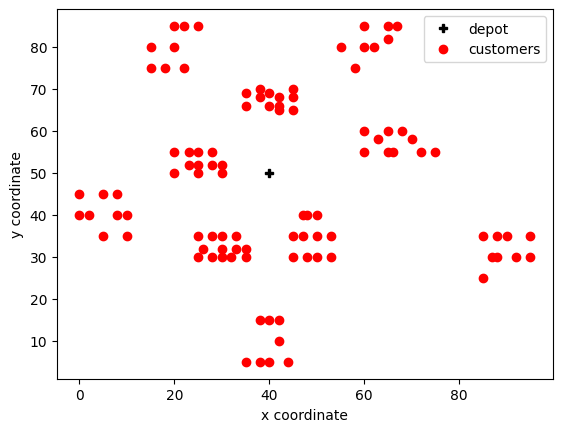

### EVOLUTION START ###
gen	evals	avg    	std    	min    	max   
1  	80   	49247.5	49334.8	0.93769	106645
2  	80   	50165.7	50262.6	0.905799	110400
3  	80   	49436.5	49554.1	0.899995	111112
4  	80   	48643.9	48804.5	0.920531	108633
5  	80   	48940  	49096.7	0.938858	106512
6  	80   	48988.6	49132.7	0.934166	107047
7  	80   	49259.4	49405.9	0.913653	109451
8  	80   	48951.6	49193.6	0.899948	111118
9  	80   	48976.4	49185  	0.91884 	108833
10 	80   	49120.1	49336  	0.893837	111877
11 	80   	49173.2	49373  	0.908665	110052
12 	80   	49301.9	49432.3	0.938195	106588
13 	80   	48932.4	49196.1	0.90503 	110494
14 	80   	49393.5	49534.1	0.923811	108247
15 	80   	48824.8	49084.2	0.922088	108450
16 	80   	49275.1	49510.1	0.904586	110548
17 	80   	48834.6	49043.3	0.935922	106846
18 	80   	48620.3	48888.6	0.925039	108104
19 	80   	48742.3	48977.9	0.944144	105916
20 	80   	48361.5	48589.9	0.896734	111516
21 	80   	48425  	48687.3	0.939002	106496
22 	80   	48296.9	48599.1	0.914852	109307
23 	80   	47

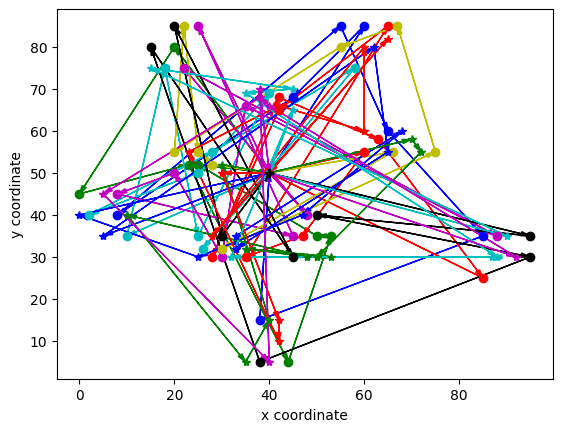

[[97, 1, 33, 100, 88, 81, 59],
 [15, 39, 27, 53, 74, 62, 25],
 [90, 66, 40, 93, 5, 48, 4, 89, 80],
 [31, 17, 52, 6, 24, 37, 23, 98, 50],
 [65, 13, 78, 10, 45, 29, 34, 69, 12],
 [86, 46, 82, 92, 99, 30, 14, 26, 22],
 [71, 63, 70, 58, 19, 68, 16, 47],
 [35, 95, 87, 42, 43, 85, 67, 51, 38],
 [84, 83, 61, 72, 41, 64, 32, 60, 57, 21],
 [20, 55, 54, 28, 3, 91, 96, 49, 94],
 [76, 18, 2, 11, 77, 79, 44, 75],
 [73, 7, 8, 36, 56, 9]]

In [60]:
run_pso(instance_name=problem_name, particle_size=customers_count, pop_size=particles_pop_size,
                      max_iteration=max_generations, cognitive_coef=cognitive_acceleration,
                      social_coef=social_acceleration, s_limit=speed_limit, plot=plot_result)